In [ ]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install transformers torch pandas scikit-learn --quiet

In [1]:
from sentence_transformers import SentenceTransformer
import pandas as pd

In [3]:
# Load your CSV
df = pd.read_csv("social_media_stream.csv")
texts = df['text'].dropna().sample(n=2000, random_state=42).tolist()

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
embeddings = model.encode(texts, show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

In [10]:
import numpy as np
import re
import pandas as pd

# Limit to a sample with Zone mentioned
tweets_df = pd.read_csv('social_media_stream.csv', low_memory=False, encoding='utf-8', on_bad_lines='skip')
sensor_df = pd.read_csv('sensor_readings.csv', low_memory=False, encoding='utf-8', on_bad_lines='skip')

# Extract Zone
tweets_df['zone'] = tweets_df['text'].apply(lambda x: re.search(r'\bZone\s+[A-Z]\b', x).group(0) if re.search(r'\bZone\s+[A-Z]\b', x) else None)

# Parse timestamps
tweets_df['timestamp'] = pd.to_datetime(tweets_df['timestamp'], errors='coerce')
sensor_df['timestamp'] = pd.to_datetime(sensor_df['timestamp'], errors='coerce')

# Filter tweets that mention a zone and limit to 500 for performance
tweets_sample = tweets_df[tweets_df['zone'].notnull()].copy()

# Filter humidity sensor logs (for floods)
humidity_sensors = sensor_df[sensor_df['sensor_type'] == 'humidity'].copy()

# Pre-calculate lat/lon arrays
sensor_lat = humidity_sensors['latitude'].values
sensor_lon = humidity_sensors['longitude'].values
sensor_times = humidity_sensors['timestamp'].values

# Define a function to compute time difference from nearest sensor event
def compute_temporal_score(row):
    # Filter by lat/lon box ±0.1 degrees
    lat_diffs = np.abs(sensor_lat - row['latitude'])
    lon_diffs = np.abs(sensor_lon - row['longitude'])
    spatial_mask = (lat_diffs < 0.1) & (lon_diffs < 0.1)

    if not np.any(spatial_mask):
        return pd.Series({'time_diff_minutes': None, 'temporal_score': 0})
    nearby_times = sensor_times[spatial_mask]
    time_diffs = np.abs((nearby_times - np.datetime64(row['timestamp'])) / np.timedelta64(1, 'm'))
    min_diff = np.min(time_diffs)

    score = 1 if min_diff <= 15 else 0
    return pd.Series({'time_diff_minutes': round(min_diff, 1), 'temporal_score': score})

# Apply
tweets_sample[['time_diff_minutes', 'temporal_score']] = tweets_sample.apply(compute_temporal_score, axis=1)

# Show result
tweets_sample.head()

#print real and fake tweet count
print(tweets_sample['temporal_score'].value_counts())


temporal_score
0.0    15081
1.0     4841
Name: count, dtype: int64


In [14]:
# Show full count of temporal_score values for all records
full_tweets_df = pd.read_csv('social_media_stream.csv', low_memory=False, encoding='utf-8', on_bad_lines='skip')
sensor_df = pd.read_csv('sensor_readings.csv', low_memory=False, encoding='utf-8', on_bad_lines='skip')

# Extract Zone
import re
full_tweets_df['zone'] = full_tweets_df['text'].apply(lambda x: re.search(r'\bZone\s+[A-Z]\b', x).group(0) if re.search(r'\bZone\s+[A-Z]\b', x) else None)

# Parse timestamps
full_tweets_df['timestamp'] = pd.to_datetime(full_tweets_df['timestamp'], errors='coerce')
sensor_df['timestamp'] = pd.to_datetime(sensor_df['timestamp'], errors='coerce')

# Filter humidity sensors for flood event detection
humidity_sensors = sensor_df[sensor_df['sensor_type'] == 'humidity'].copy()

# Sensor location and timestamps
sensor_lat = humidity_sensors['latitude'].values
sensor_lon = humidity_sensors['longitude'].values
sensor_times = humidity_sensors['timestamp'].values

# Compute temporal score for full dataset
def compute_temporal_score(row):
    try:
        lat_diffs = np.abs(sensor_lat - row['latitude'])
        lon_diffs = np.abs(sensor_lon - row['longitude'])
        spatial_mask = (lat_diffs < 0.1) & (lon_diffs < 0.1)

        if not np.any(spatial_mask):
            return pd.Series({'time_diff_minutes': None, 'temporal_score': 0})

        nearby_times = sensor_times[spatial_mask]
        time_diffs = np.abs((nearby_times - np.datetime64(row['timestamp'])) / np.timedelta64(1, 'm'))
        min_diff = np.min(time_diffs)

        score = 1 if min_diff <= 15 else 0
        return pd.Series({'time_diff_minutes': round(min_diff, 1), 'temporal_score': score})
    except:
        return pd.Series({'time_diff_minutes': None, 'temporal_score': 0})

# Apply to all rows
full_tweets_df[['time_diff_minutes', 'temporal_score']] = full_tweets_df.apply(compute_temporal_score, axis=1)

#show
print(full_tweets_df['temporal_score'].value_counts())

temporal_score
0.0    37782
1.0    12218
Name: count, dtype: int64


In [15]:
# Add a new column with final label based on temporal_score
full_tweets_df['final_label'] = full_tweets_df['temporal_score'].apply(lambda x: 'Likely Real' if x == 1 else 'Likely Fake')

# Save updated file with label
labeled_path = "social_media_labeled.csv"
full_tweets_df.to_csv(labeled_path, index=False)

labeled_path

'social_media_labeled.csv'

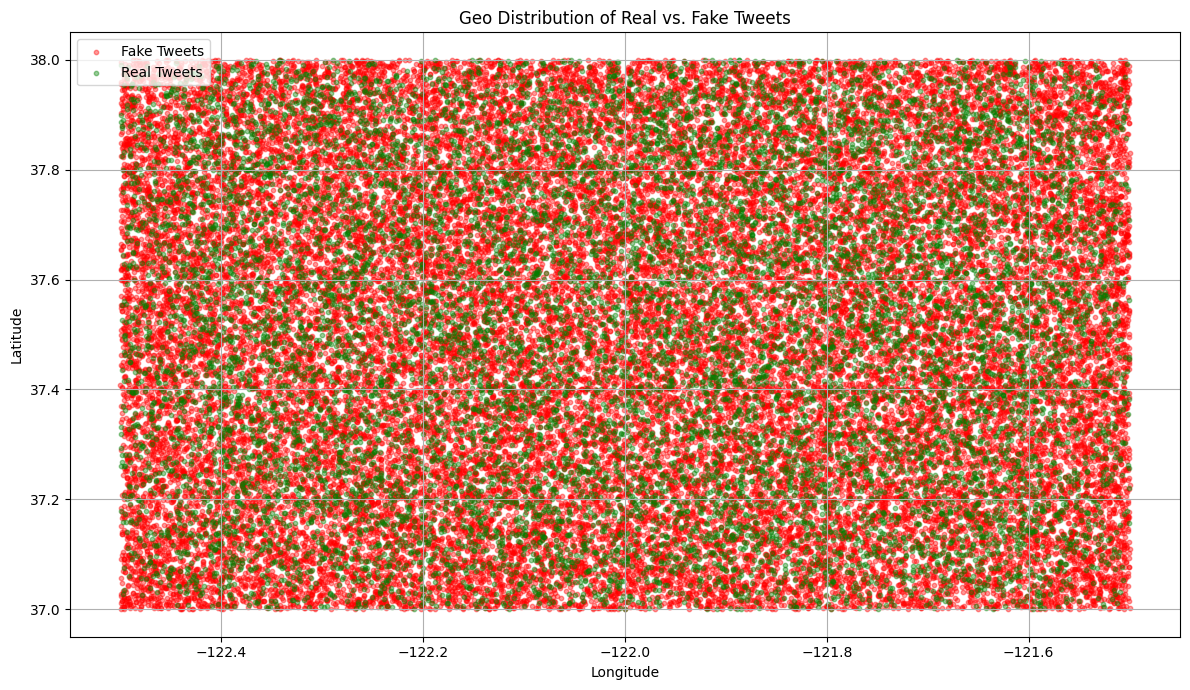

In [16]:
import matplotlib.pyplot as plt

# Separate fake and real tweets
fake_tweets = full_tweets_df[full_tweets_df['final_label'] == 'Likely Fake']
real_tweets = full_tweets_df[full_tweets_df['final_label'] == 'Likely Real']

# Plot
plt.figure(figsize=(12, 7))
plt.scatter(fake_tweets['longitude'], fake_tweets['latitude'], alpha=0.4, s=10, label='Fake Tweets', color='red')
plt.scatter(real_tweets['longitude'], real_tweets['latitude'], alpha=0.4, s=10, label='Real Tweets', color='green')
plt.title("Geo Distribution of Real vs. Fake Tweets")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
import folium
from folium.plugins import MarkerCluster

# Create the base map
m = folium.Map(location=[37.7, -122.2], zoom_start=9)

# Create a marker cluster
marker_cluster = MarkerCluster().add_to(m)

# Add Real Tweets
for _, row in real_tweets.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='green',
        fill=True,
        fill_opacity=0.4,
        popup=f"Real: {row['text'][:100]}"
    ).add_to(marker_cluster)

# Add Fake Tweets
for _, row in fake_tweets.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.4,
        popup=f"Fake: {row['text'][:100]}"
    ).add_to(marker_cluster)

# Add Legend with HTML + CSS
legend_html = """
<div style="
position: fixed;
bottom: 50px;
left: 50px;
width: 150px;
z-index:9999;
font-size:14px;
background-color: white;
border:2px solid grey;
border-radius:5px;
padding: 10px;
">
<b>Legend</b><br>
<i style="background:green; width:10px; height:10px; display:inline-block;"></i> Real Tweet<br>
<i style="background:red; width:10px; height:10px; display:inline-block;"></i> Fake Tweet
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Save map with legend
map_path = "tweet_fake_real_map_with_legend.html"
m.save(map_path)
map_path

'tweet_fake_real_map_with_legend.html'